# self-attention

## setup

In [457]:
import numpy as np
import math
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [458]:
EMBED_SIZE = 8
VOCAB_SIZE = 11
HIDDEN_SIZE = 32
CONTEXT_SIZE = 10
MAGIC_TOKEN = VOCAB_SIZE - 1
EPOCHS = 10000
LEARNING_RATE = 3e-4
DROPOUT = 0.1

In [459]:
X = []
Y = []

for i in range(10000):
  magic_token_idx = random.randint(1, CONTEXT_SIZE/2 - 1)
  x = [random.randint(1,VOCAB_SIZE-2) for _ in range(magic_token_idx)] + [MAGIC_TOKEN] + [0 for _ in range(CONTEXT_SIZE - magic_token_idx - 1)]
  y = x[:magic_token_idx+1] + x[:magic_token_idx] + [0 for _ in range(CONTEXT_SIZE - 2 * magic_token_idx - 1)]
  X.append(x)
  Y.append(y)

X = torch.tensor(X).to(device)
Y= torch.tensor(Y).to(device)

## code

In [460]:
def get_training():
  X = torch.tensor([[0, 1, 2, 3],
                    [3, 2, 1, 0]])

  X = torch.randint(0, VOCAB_SIZE-2, (1000, CONTEXT_SIZE))

  Y = torch.ones_like(X) # TODO
  return X.to(device), Y.to(device)

In [461]:
activations = {}

class Attention(nn.Module):
  def __init__(self):
    super().__init__()
    self.w_key = torch.nn.Linear(EMBED_SIZE, EMBED_SIZE, bias=False)
    self.w_query = torch.nn.Linear(EMBED_SIZE, EMBED_SIZE, bias=False)
    self.w_value = torch.nn.Linear(EMBED_SIZE, EMBED_SIZE, bias=False)
    self.ln = nn.LayerNorm(EMBED_SIZE)
    self.dropout = nn.Dropout(DROPOUT)

  def forward(self, x):
    # generate K,Q,V
    key = self.w_key(x)
    query = self.w_query(x)
    value = self.w_value(x)
    # pre-layernorm
    x = self.ln(x)
    # do the attention
    correlation = query @ key.transpose(-2, -1)
    correlation = correlation / math.sqrt(key.shape[-1])
    correlation = F.softmax(correlation, dim=-1)
    activations['x'] = correlation.detach()
    new_embedding = correlation @ value
    # post-layernorm
    # new_embedding = self.ln(new_embedding)
    new_embedding = self.dropout(new_embedding)
    return new_embedding

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedding = nn.Embedding(VOCAB_SIZE, EMBED_SIZE)
    self.positional_embedding = nn.Embedding(CONTEXT_SIZE, EMBED_SIZE)
    self.attention = Attention()
    self.ff = nn.Sequential(
      nn.LayerNorm(EMBED_SIZE),
      nn.Linear(EMBED_SIZE, HIDDEN_SIZE),
      nn.ReLU(),
      nn.Linear(HIDDEN_SIZE, EMBED_SIZE),
      # nn.LayerNorm(EMBED_SIZE),
      nn.Dropout(DROPOUT)
    )
    self.head = nn.Linear(EMBED_SIZE, VOCAB_SIZE)

  def forward(self, x):
    # (batch_size, context_size)
    x = self.token_embedding(x)  # (batch_size, context_size, embedding_size)
    # positional encoding
    x = x + self.positional_embedding(torch.arange(0, x.shape[1]).to(device))
    # attention
    x = x + self.attention(x)
    # feed forward
    x = x + self.ff(x)
    # head
    x = self.head(x)
    return x

In [519]:
from sklearn.decomposition import PCA
import numpy as np

In [462]:
model = Net().to(device)

In [463]:
positional_embeddings = {}

def train(model, epochs=EPOCHS, lr=LEARNING_RATE):
  model.train()
  opt = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    out = model(X)
    loss = F.cross_entropy(out.view(-1, out.shape[-1]), Y.view(-1))
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 500 == 0:
      print(f'{epoch:5} {loss.item()}')

train(model, epochs=10000, lr=3e-4)

    0 3.0705606937408447
  500 1.46987783908844
 1000 0.97285395860672
 1500 0.6806401610374451
 2000 0.52947998046875
 2500 0.42895203828811646
 3000 0.36064377427101135
 3500 0.30293935537338257
 4000 0.26312580704689026
 4500 0.24366405606269836
 5000 0.22774851322174072
 5500 0.21753673255443573
 6000 0.20877674221992493
 6500 0.20217610895633698
 7000 0.19641633331775665
 7500 0.19441324472427368
 8000 0.1898036003112793
 8500 0.18338820338249207
 9000 0.18103349208831787
 9500 0.17713601887226105


In [464]:
model.eval()
res = model(X).argmax(-1)
correct = ((res == Y).float().sum(-1) == CONTEXT_SIZE).float().sum()
print(f'accuracy: {correct / len(X)}')
res[:20]

accuracy: 0.4814999997615814


tensor([[ 2,  6,  9,  2, 10,  2,  6,  9,  2,  0],
        [ 4, 10,  4,  0,  0,  0,  0,  0,  0,  0],
        [ 2, 10,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  9, 10,  2,  6,  0,  0,  0,  0,  0],
        [ 6,  2,  4,  7, 10,  2,  2,  4,  7,  0],
        [ 7,  9, 10,  7,  7,  0,  0,  0,  0,  0],
        [ 9,  3,  3,  9, 10,  9,  3,  3,  9,  0],
        [ 6,  7,  5, 10,  6,  7,  7,  0,  0,  0],
        [ 3,  1,  1, 10,  3,  1,  1,  0,  0,  0],
        [ 8,  9,  3, 10,  9,  9,  9,  0,  0,  0],
        [ 9,  8, 10,  9,  9,  0,  0,  0,  0,  0],
        [ 1,  8,  6,  3, 10,  4,  9,  6,  3,  0],
        [ 4,  1,  3, 10,  4,  1,  3,  0,  0,  0],
        [ 6, 10,  6,  0,  0,  0,  0,  0,  0,  0],
        [ 4, 10,  4,  0,  0,  0,  0,  0,  0,  0],
        [ 4,  7, 10,  4,  7,  0,  0,  0,  0,  0],
        [ 5, 10,  5,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  6, 10,  1,  6,  0,  0,  0,  0,  0],
        [ 2, 10,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  7,  1, 10,  1,  1,  1,  0,  0,  0]],

In [552]:
from collections import Counter
cs = Counter("12218123")
res = ""
for i in range(10):
    res += f'{i}' * cs[i]
res 

''

tensor([[ 7,  1,  9,  2, 10,  7,  1,  9,  2,  0]], device='cuda:0')


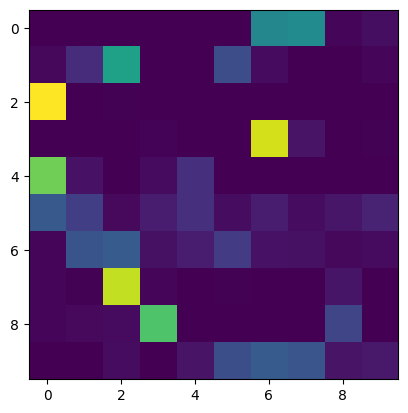

In [515]:
model.eval()
res = model(torch.tensor([[7,1,9,2,10,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[1,2,10,0,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[8,10,0,0,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[8,3,4,10,0,0,0,0,0,0]]).to(device)).argmax(-1)
print(res)

_ = plt.imshow(activations['x'].squeeze().cpu())

In [466]:
# save
# ----
# torch.save(model.state_dict(), 'weights/copy-task-500k-epochs.pt')

# load
# ----
# m = Net().to(device)
# m.load_state_dict(torch.load('weights/copy-task-500k-epochs.pt'))

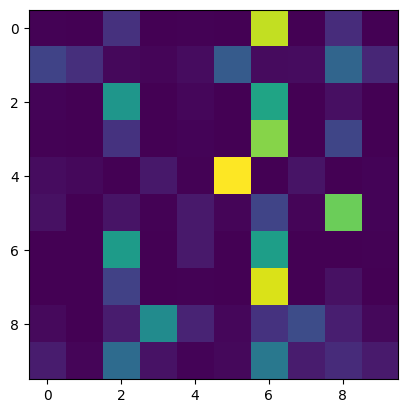

In [467]:
m(torch.tensor([[8,8,8,8,10,8,8,8,8,0]], device=device)).argmax(-1).tolist()[:10]
_ = plt.imshow(activations['x'].squeeze().cpu())

## testing ideas

ideas requiring positional encoding / attention:
1) additions using LLM
2) arithmetic / geometric sequence prediction 1, 3, 5 ? → 7  or 2, 4, 8, ? → 16
3) (BOW?) sort 1, 3, 2, 4, 1 → 1, 1, 2, 3, 4
4) parens summation: (2 2 3) (4 5) → 7, 9
5) substring extraction between markers: 1, 4, 56, 10, 43, 54, 56, 6, 10 → 43, 54, 56, 6

## visualize positional embeddings

### dot product

### dotproduct / cosine distance

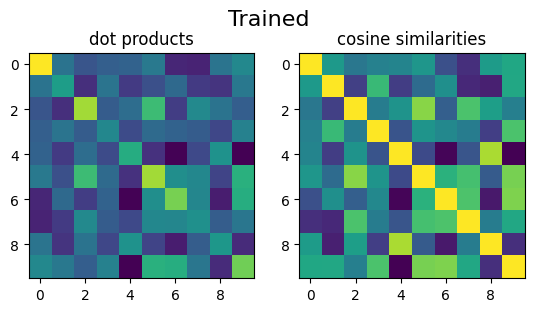

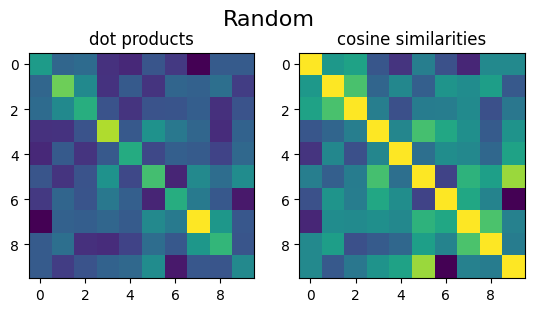

In [587]:
def plot_positional_embeddings_relations(model, title):
    x = model.positional_embedding.weight.data.detach().cpu()
    dot_products = x @ x.T
    x_norm = x / x.norm(dim=1, keepdim=True)
    cosine_similarities = x_norm @ x_norm.T
    # plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(dot_products)
    ax[0].set_title('dot products')
    ax[1].imshow(cosine_similarities)
    ax[1].set_title('cosine similarities')
    fig.text(0.5, 0.8, title, ha='center', va='center', fontsize=16)
    plt.show()

m2 = Net()
plot_positional_embeddings_relations(model, 'Trained')
plot_positional_embeddings_relations(m2, 'Random')

### PCA

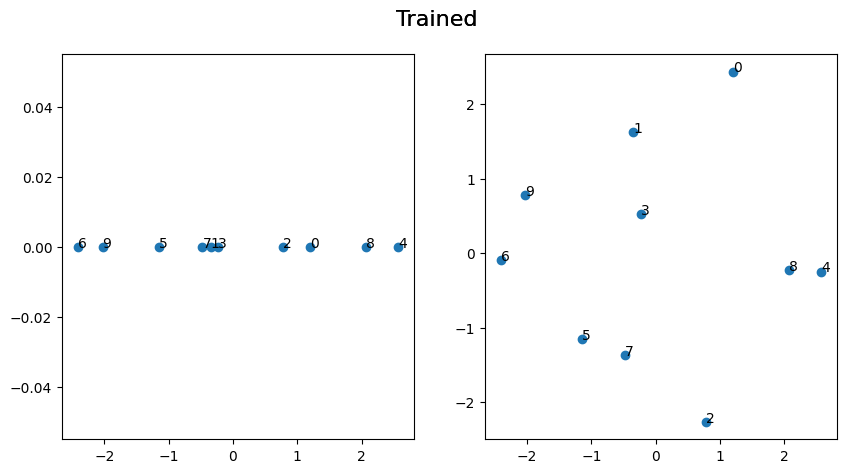

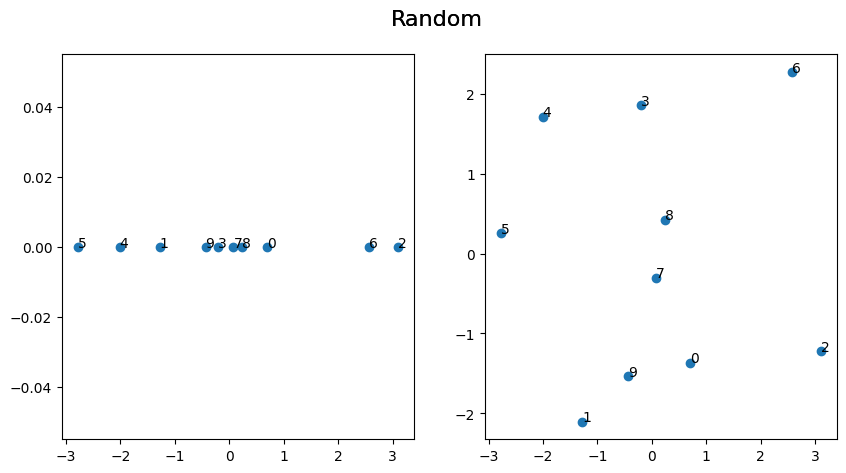

In [639]:
def plot_positional_embeddings_pca(model, title='', figsize=(10, 5)):
    def reduce_dims(x, dim):
        pca = PCA(n_components=dim)
        y = pca.fit_transform(x)
        if dim == 1: return y[:, 0], np.zeros_like(y[:, 0])
        return y[:, 0], y[:, 1]

    x = model.positional_embedding.weight.data.detach().cpu().numpy()
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for j, dim in enumerate([1, 2]):
        xs, ys = reduce_dims(x, dim)
        # plot
        ax[j].scatter(xs, ys, label='pca dim=2')
        for i in range(xs.shape[0]):
            ax[j].annotate(f'{i}', xy=(xs[i], ys[i]))
        fig.text(0.5, 0.95, title, ha='center', va='center', fontsize=16)

m2 = Net()
plot_positional_embeddings_pca(model, 'Trained')
plot_positional_embeddings_pca(m2, 'Random')